In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Attempting uninstall: cellnet
    Found existing installation: cellnet 0.1.0
    Can't uninstall 'cellnet'. No files were found to uninstall.
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
from os.path import join

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd
import torch
import matplotlib.pyplot as plt

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'
CKPT_PATH = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default/w_augment_4/checkpoints/val_f1_macro_epoch=45_val_f1_macro=0.847.ckpt'

In [3]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
tissue_general = dd.read_parquet(join(DATA_PATH, 'test'), columns='tissue_general').compute().to_numpy()
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

# Load model & predict

In [4]:
from utils import correct_labels

In [5]:
estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=1024)
estim.model = TabnetClassifier.load_from_checkpoint(CKPT_PATH, **estim.get_fixed_model_params('tabnet'))
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
probas = estim.predict(estim.datamodule.test_dataloader())
y_pred = np.argmax(probas, axis=1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 3368/3368 [12:32<00:00,  4.48it/s]


In [7]:
assert y_pred.shape[0] == y_true.shape[0]
y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)

# Classification performance

In [8]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

#### Overall performance

In [9]:
clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

precision    recall  f1-score       support
accuracy       0.907540  0.907540  0.907540  9.075400e-01
macro avg      0.822742  0.852199  0.830267  3.448832e+06
weighted avg   0.912285  0.907540  0.907862  3.448832e+06

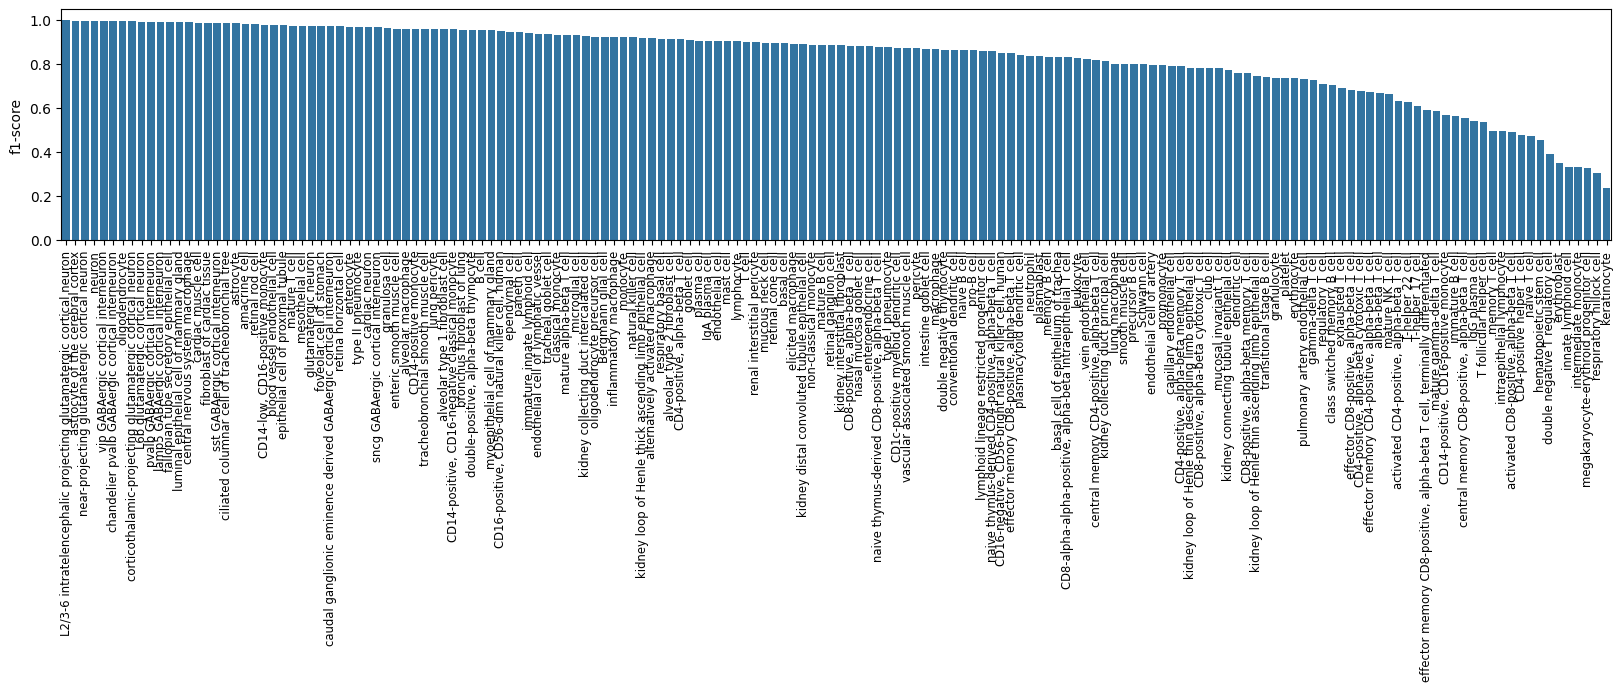

In [10]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
    color='#1f77b4'
)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.xaxis.set_tick_params(labelsize='small');

#### Per cell type performance vs number of donors

In [11]:
cells_per_cell_type = (
    dd.read_parquet(join(DATA_PATH, 'train'), columns=['cell_type', 'tech_sample'])
    .groupby('cell_type')['tech_sample']
    .size()
).compute()

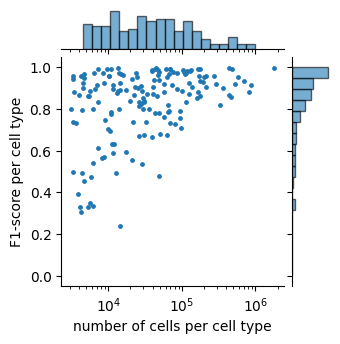

In [12]:
assert np.array_equal(
    clf_report_per_class['f1-score'].index.to_numpy().astype('i8'),
    cells_per_cell_type.index.to_numpy()
)

df = clf_report_per_class[['f1-score']].copy()
df['n_cells'] = cells_per_cell_type.to_numpy()
g = sns.JointGrid(x='n_cells', y='f1-score', data=df, height=3.5, marginal_ticks=False)
g = g.plot_joint(plt.scatter, s=6)
g.ax_marg_x.hist(df['n_cells'], bins=np.geomspace(4500, 1e6, 20), alpha=.6, edgecolor='black')
g.ax_marg_y.hist(df['f1-score'], bins=np.linspace(0, 1, 20), alpha=.6, orientation='horizontal', edgecolor='black')
g.set_axis_labels('number of cells per cell type', 'F1-score per cell type')
g.ax_joint.set_xscale('log')

g.ax_joint.get_figure().savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/f1-score_vs_n-cells.pdf', format='pdf')
g.ax_joint.get_figure().savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/f1-score_vs_n-cells.png', format='png', dpi=300)

In [13]:
easy_celltypes = (
    df
    .query('`f1-score` > 0.9 & `n_cells` < 10000')
    .assign(
        cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
    )
)

easy_celltypes.cell_type.tolist()

['Bergmann glial cell',
 'L6b glutamatergic cortical neuron',
 'alternatively activated macrophage',
 'bronchus fibroblast of lung',
 'cardiac neuron',
 'caudal ganglionic eminence derived GABAergic cortical interneuron',
 'chandelier pvalb GABAergic cortical interneuron',
 'ependymal cell',
 'inflammatory macrophage',
 'lung pericyte',
 'paneth cell',
 'renal interstitial pericyte',
 'retina horizontal cell']

In [14]:
easy_celltypes.sort_values('f1-score', ascending=False)

f1-score  n_cells                                          cell_type
47   0.993885     7268    chandelier pvalb GABAergic cortical interneuron
20   0.992800     9727                  L6b glutamatergic cortical neuron
43   0.973098     6299  caudal ganglionic eminence derived GABAergic c...
149  0.971226     8530                             retina horizontal cell
42   0.967201     4629                                     cardiac neuron
103  0.959292     3254                                      lung pericyte
39   0.956621     4299                        bronchus fibroblast of lung
69   0.948148     4709                                     ependymal cell
134  0.946496     3328                                        paneth cell
1    0.924838     4564                                Bergmann glial cell
85   0.923077     8629                            inflammatory macrophage
29   0.917476     7041                 alternatively activated macrophage
146  0.902137     4455                        renal interstitial pericyte

In [15]:
hard_celltypes = (
    df
    .query('`f1-score` < 0.4 & `n_cells` < 10000')
    .assign(
        cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
    )
)

hard_celltypes.cell_type.tolist()

['double negative T regulatory cell',
 'erythroblast',
 'innate lymphoid cell',
 'intermediate monocyte',
 'megakaryocyte-erythroid progenitor cell',
 'respiratory hillock cell']

In [16]:
hard_celltypes.sort_values('f1-score', ascending=False)

f1-score  n_cells                                cell_type
55   0.393056     3843        double negative T regulatory cell
71   0.351064     5593                             erythroblast
86   0.332346     6214                     innate lymphoid cell
87   0.332178     4082                    intermediate monocyte
113  0.328518     5346  megakaryocyte-erythroid progenitor cell
148  0.307177     4270                 respiratory hillock cell

# Visualize predictions

In [13]:
import yaml

import anndata
import scanpy as sc
import matplotlib.pyplot as plt

In [166]:
with open('shortend_cell_types.yaml', 'r') as f:
    shortend_cell_types = yaml.safe_load(f)

In [15]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300 # If 'figure', uses the figure's dpi value.

sc.settings.figdir = '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/'

## predictions vs true labels

#### Compute embeddings

Plot TSNE embedding (based on 50 PCA components of the input features) and super-impose true labels and predicted labels

In [66]:
adata = anndata.AnnData(
    X=np.load(join(DATA_PATH, 'pca/x_pca_test_50.npy')), 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten(),
        'tissue': tissue_general_mapping.loc[tissue_general].to_numpy().flatten()
    })
)
adata.obs['wrong_prediction'] = (adata.obs.y_true != adata.obs.y_pred).astype(str).astype('category')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
sc.pp.subsample(adata, n_obs=200_000)
sc.tl.tsne(adata, use_rep='X')

In [ ]:
adata.write_h5ad('adata_tabnet.h5ad')

#### Plot embeddings

In [4]:
adata = anndata.read_h5ad('adatas/adata_tabnet.h5ad')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


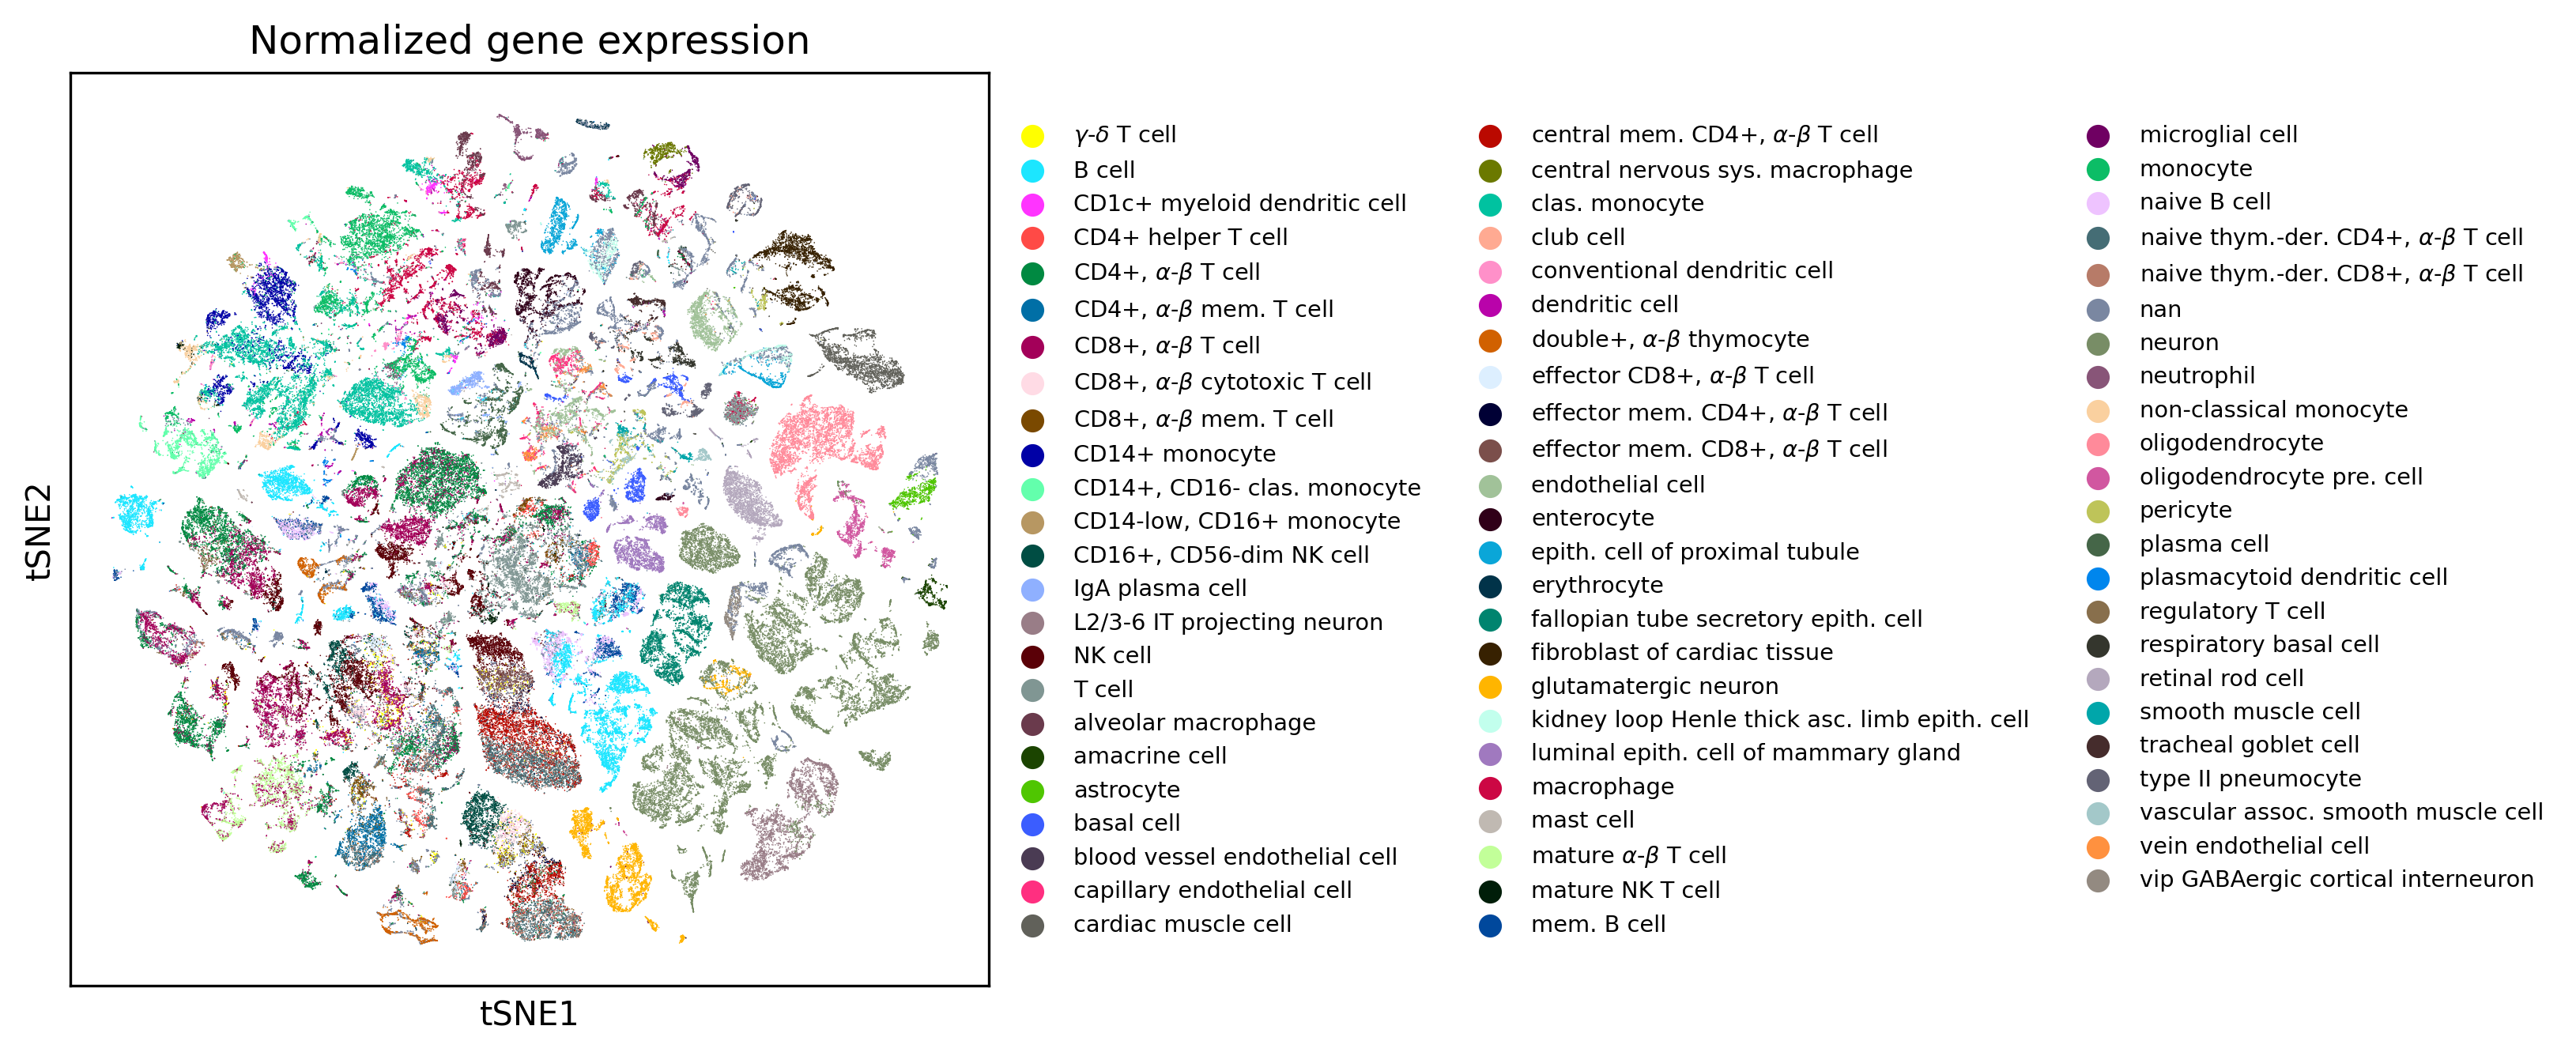

In [5]:
plt.rcParams['figure.figsize'] = (5, 5)

cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq.index.tolist()[:70]
adata_plot = adata.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot)).astype(str)
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot)).astype(str)

# convert to shortened cell type names
adata_plot.obs['y_pred'] = adata_plot.obs['y_pred'].replace(shortend_cell_types)
adata_plot.obs['y_true'] = adata_plot.obs['y_true'].replace(shortend_cell_types)

ax = sc.pl.tsne(
    adata_plot, 
    color='y_true', 
    legend_fontsize='x-small', 
    ncols=1, 
    title='Normalized gene expression',
    save='_raw_features.png'
)

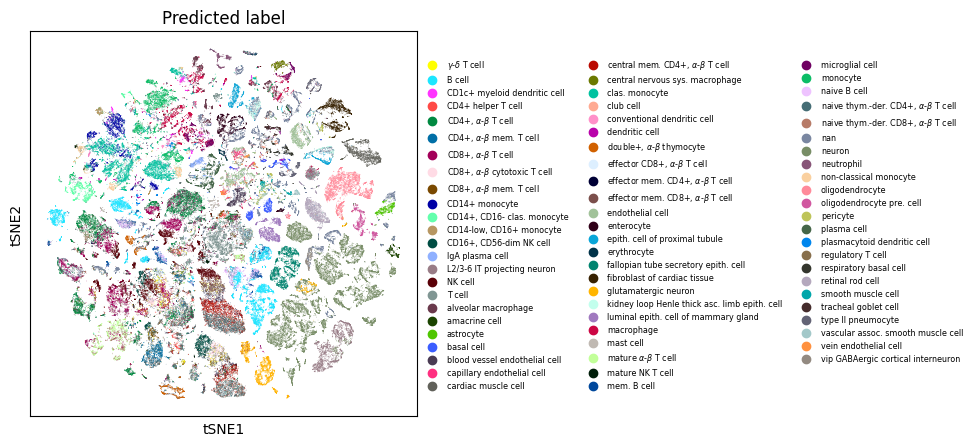

In [8]:
sc.pl.tsne(adata_plot, color='y_pred', legend_fontsize='xx-small', ncols=1, title='Predicted label')

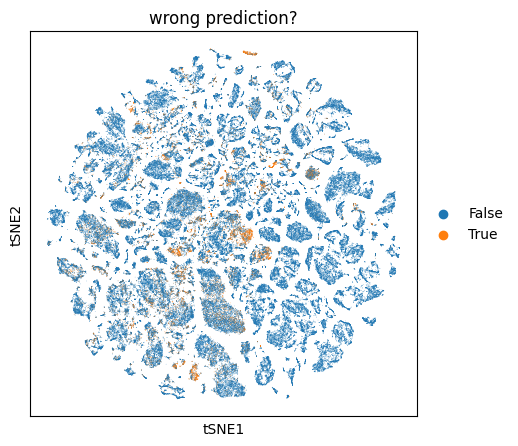

In [9]:
sc.settings.figdir = '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/'
sc.pl.tsne(
    adata, 
    color='wrong_prediction', 
    title='wrong prediction?',
    # save='_wrong_predictions.png'
)

## Visualize learned features

Plot TSNE embedding (based on last layer of trained neural network) and super-impose true labels and predicted labels

#### Compute embeddings

In [ ]:
# get feature embedding
estim.model.predict_bottleneck = True
x_emb = estim.predict(estim.datamodule.test_dataloader())
estim.model.predict_bottleneck = False

In [ ]:
adata_emb = anndata.AnnData(
    X=x_emb, 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten(),
        'tissue': tissue_general_mapping.loc[tissue_general].to_numpy().flatten()
    })
)
adata_emb.obs['wrong_prediction'] = (adata_emb.obs.y_true != adata_emb.obs.y_pred).astype(str).astype('category')

In [ ]:
sc.pp.subsample(adata_emb, n_obs=200_000)
# reduce to 50 dim before computing TSNE embedding
sc.pp.pca(adata_emb, n_comps=50)
sc.tl.tsne(adata_emb)

In [74]:
adata_emb.write_h5ad('adatas/adata_emb_tabnet.h5ad')

#### Plot embeddings

In [16]:
adata_emb = anndata.read_h5ad('adatas/adata_emb_tabnet.h5ad')

In [52]:
sc.pp.neighbors(adata_emb)
sc.tl.umap(adata_emb)

In [54]:
adata_emb.write_h5ad('adatas/adata_emb_tabnet.h5ad')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


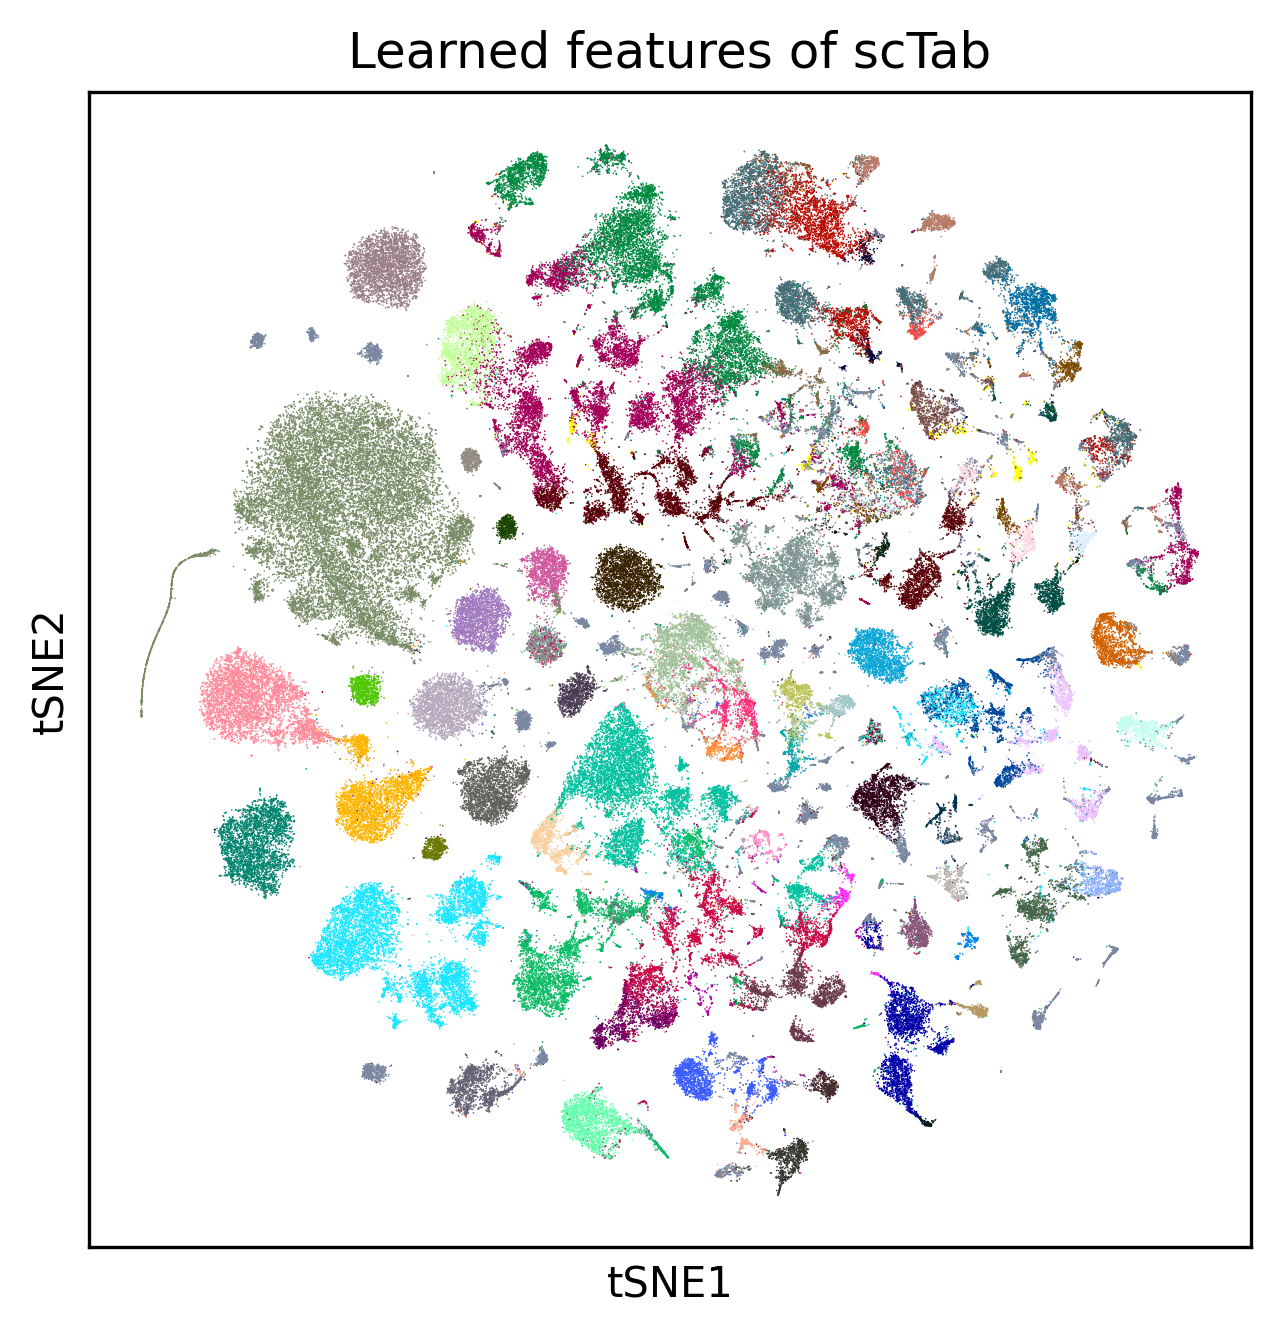

In [7]:
plt.rcParams['figure.figsize'] = (5, 5)

cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq.index.tolist()[:70]
adata_plot = adata_emb.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot)).astype(str)
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot)).astype(str)

# convert to shortened cell type names
adata_plot.obs['y_pred'] = adata_plot.obs['y_pred'].replace(shortend_cell_types)
adata_plot.obs['y_true'] = adata_plot.obs['y_true'].replace(shortend_cell_types)

ax = sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', ncols=1, title='Learned features of scTab', show=False)
ax.get_legend().remove()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/tsne_learned_features.png')

In [ ]:
!pip install -q SPARQLWrapper

In [201]:
from cellnet.utils.cell_ontology import retrieve_child_nodes_from_ubergraph


coarse_cell_types = [
    'neural cell',
    'epithelial fate stem cell',
    'endothelial cell', 
    'epithelial cell of lung',
    'oviduct glandular cell',
    'respiratory epithelial cell',
    'duct epithelial cell',
    'granulocyte',
    'B cell', 
    'B cell, CD19-positive',
    'fibroblast',
    'macrophage', 
    'monocyte', 
    'T cell',
    'natural killer cell',
    'kidney cell',
    'enterocyte',
    'cardiac muscle cell',
    'smooth muscle cell',
    'plasma cell'
]
subtypes = retrieve_child_nodes_from_ubergraph(coarse_cell_types)

adata_emb.obs['coarse_cell_type'] = np.nan
for cell_type in coarse_cell_types:
    adata_emb.obs.loc[adata_emb.obs.y_true.isin(subtypes[cell_type]), 'coarse_cell_type'] = cell_type

In [200]:
del adata_emb.uns['coarse_cell_type_colors']

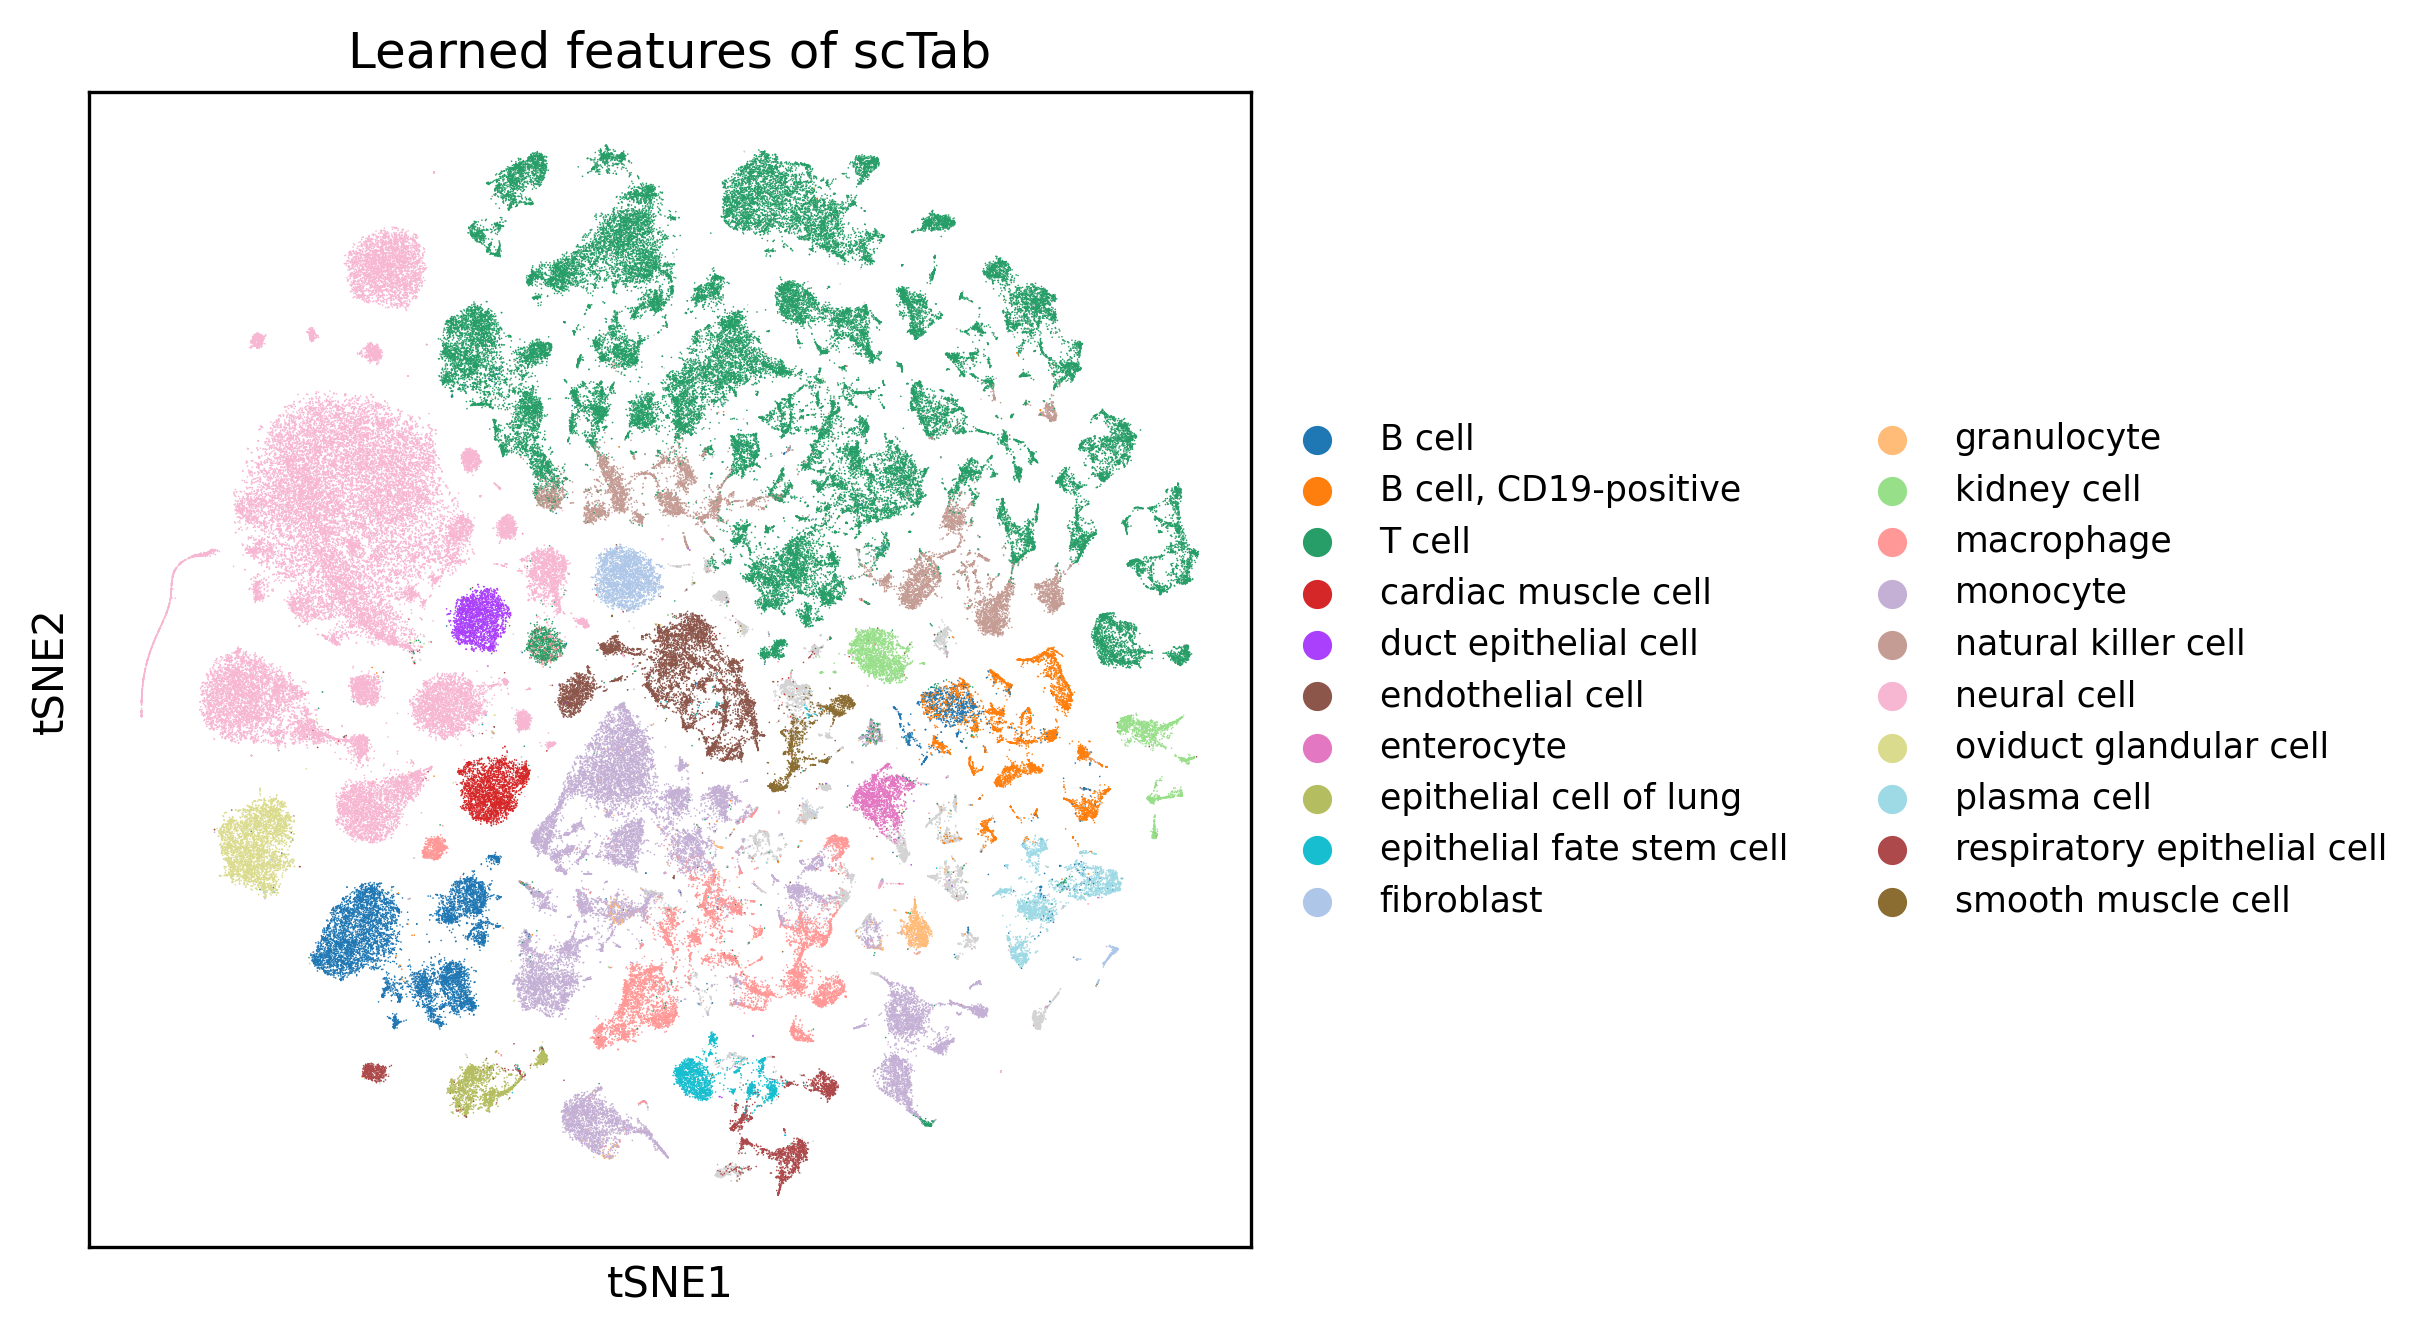

In [204]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.tsne(
    adata_emb, 
    color='coarse_cell_type', 
    legend_fontsize='small', 
    ncols=1, 
    title='Learned features of scTab', 
    na_in_legend=False,
    save='_learned_features_coarse_cell_types.png'
)


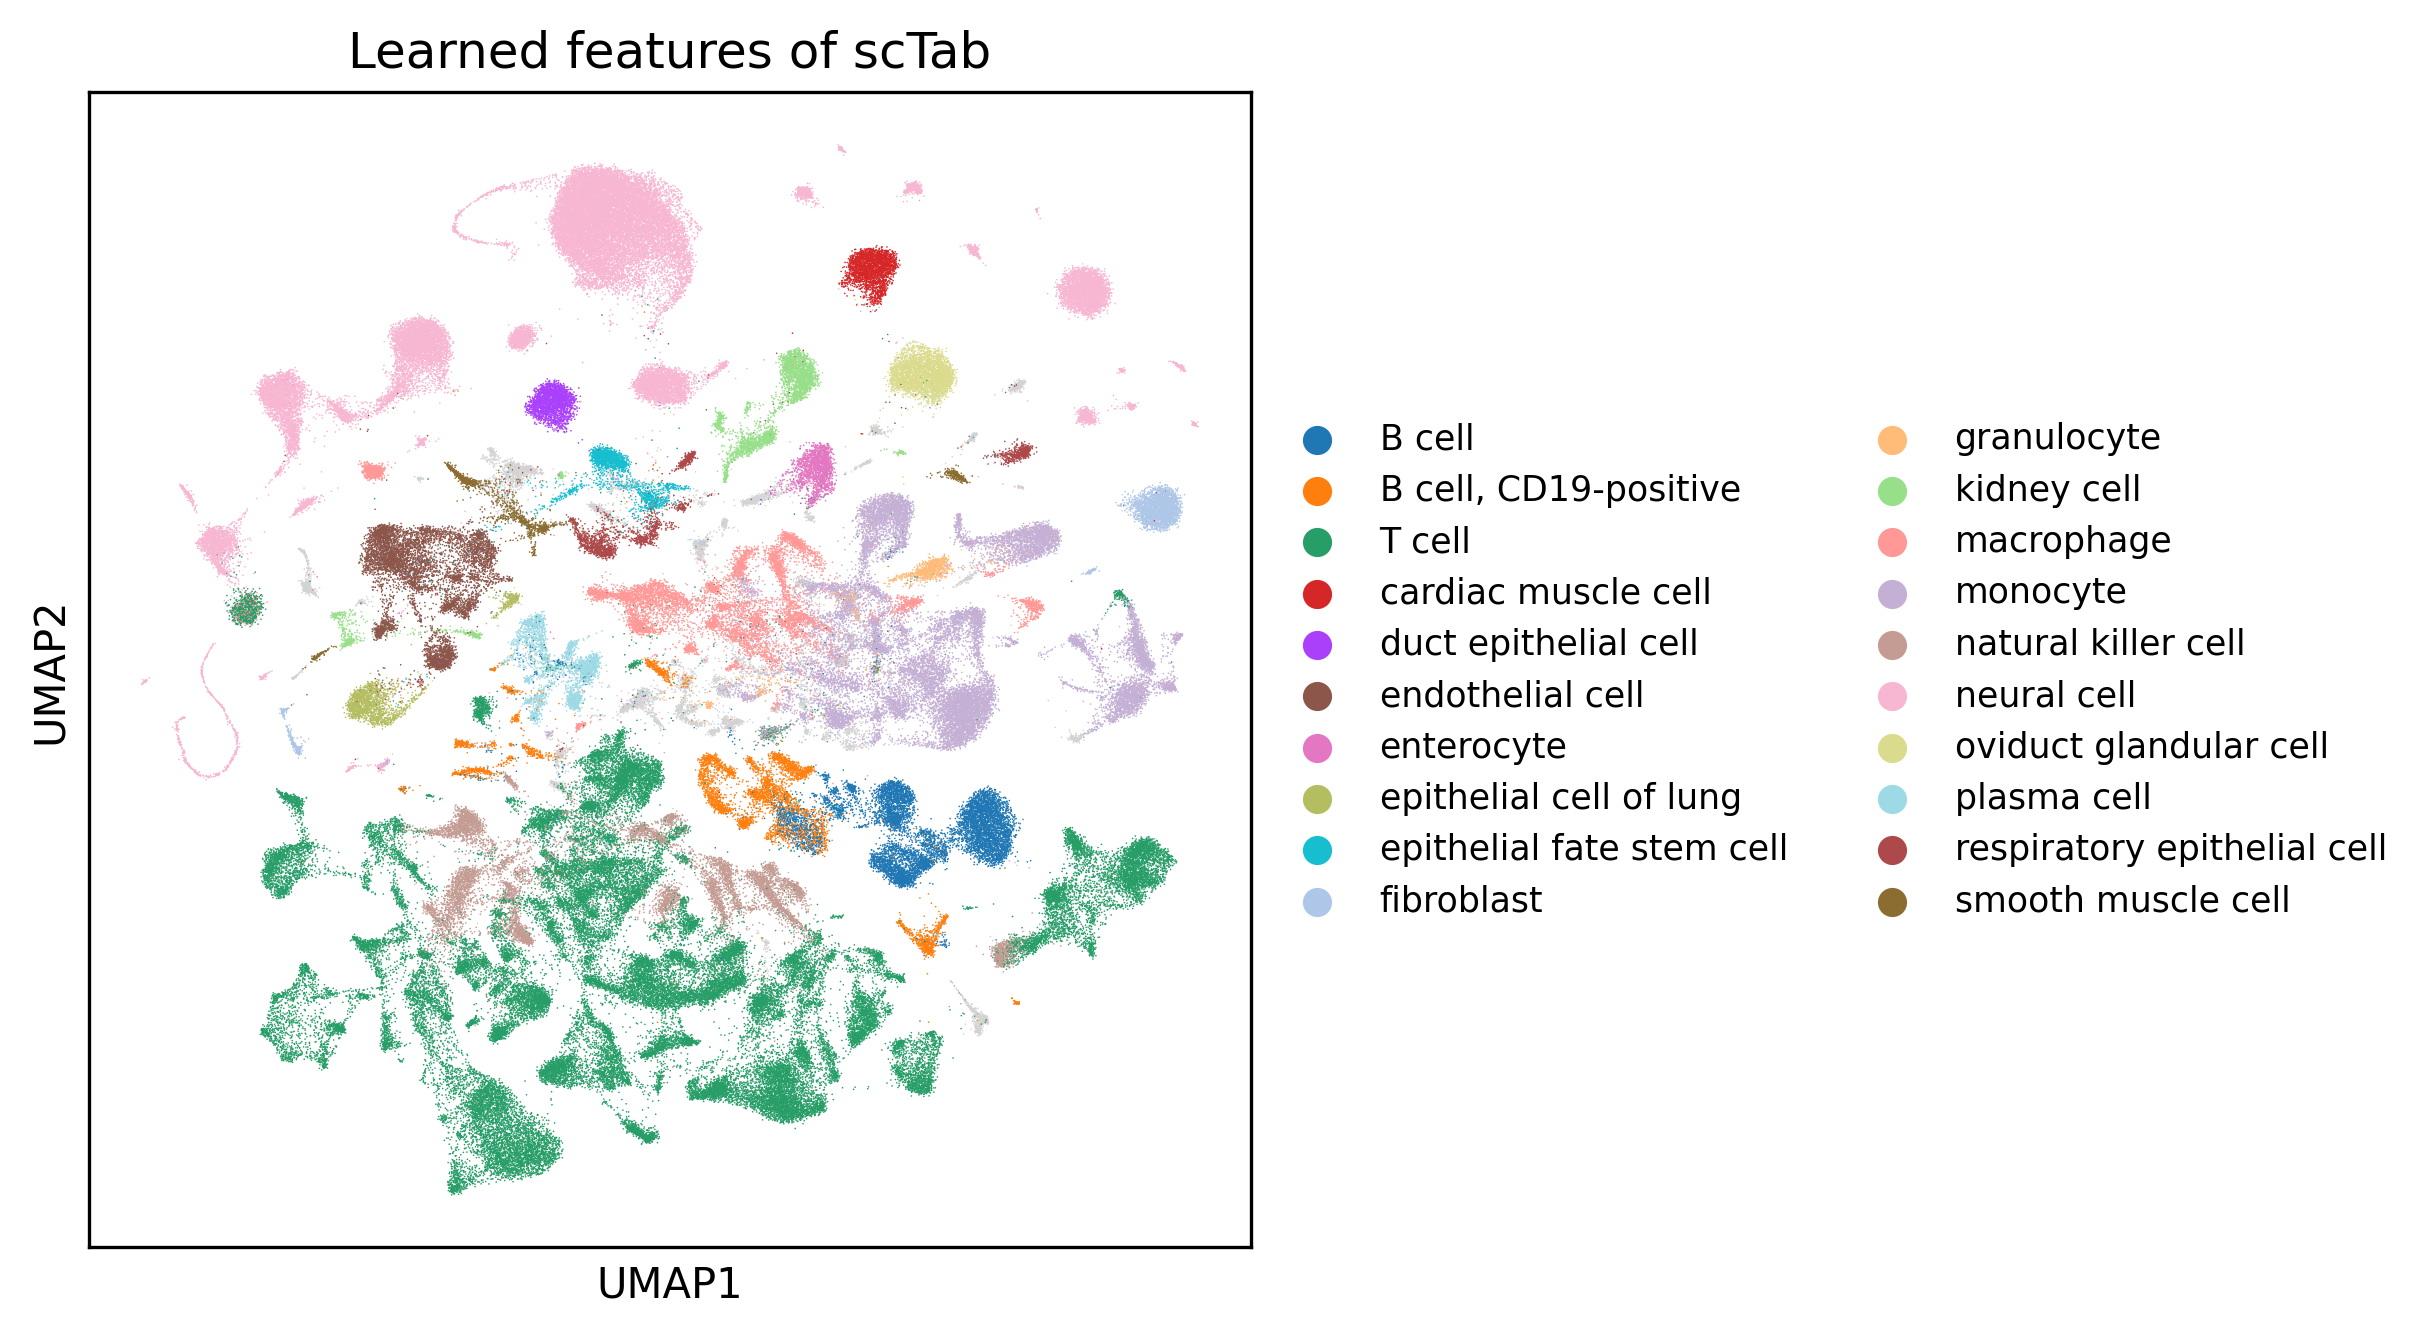

In [205]:
plt.rcParams['figure.figsize'] = (5, 5)
ax = sc.pl.umap(
    adata_emb, 
    color='coarse_cell_type', 
    legend_fontsize='small', 
    ncols=1, 
    title='Learned features of scTab', 
    na_in_legend=False,
    save='_learned_features_coarse_cell_types.png'
)